In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.manifold import TSNE
plt.rcParams["figure.figsize"] = (15,7) # make figures larger

In this notebook we will check the performance of our network. We will do the following: 1) Calculate the confusion matrix
    2) Plot the accuracy for each individual class 3) Do a T-sne plot

In [2]:
def label_to_num(name):
    label = name.split(".")[0].split("_")[1]
    if label == 'gui':
        return 0
    elif label == 'hi':
        return 1
    elif label == 'lau':
        return 2
    elif label == 'sax':
        return 3
    elif label == 'vio':
        return 4

class Audio_dataset(Dataset):


    def __init__(self,file_dir):


        self.file_dir = file_dir
        
        self.files = os.listdir(self.file_dir)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.files[idx]
        audio = torch.from_numpy(torch.load(os.path.join(self.file_dir,x)))

        audio = audio.unfold(1,50,1)

        audio = audio.permute(1,0,2)

        label = label_to_num(x)
        
        return audio,label


In [3]:
dataset_train = Audio_dataset(file_dir="./data/melspectrogram/train")

dataset_valid = Audio_dataset(file_dir="./data/melspectrogram/validation")
def customBatchBuilder(samples):
    val_values,aro_values,time_stamps,vid_name,video = zip(*samples)

    val_values = pad_sequence(val_values,padding_value=0)

    aro_values = pad_sequence(aro_values, padding_value=0)
    time_stamps = pad_sequence(time_stamps,padding_value=0)
    video = pad_sequence(video,padding_value=0)
    

    return val_values,aro_values,time_stamps,vid_name,video

In [4]:
train_loader = DataLoader(dataset_train, batch_size=1,
                        shuffle=True, num_workers=0)#,collate_fn=customBatchBuilder)
valid_loader = DataLoader(dataset_valid, batch_size=1,
                        shuffle=True, num_workers=0)#,collate_fn=customBatchBuilder)

train_set_size = len(dataset_train)

valid_set_size = len(dataset_valid)
print(train_set_size)
print(valid_set_size)

1500
340


In [5]:
audio,label = next(iter(train_loader))
print(audio.shape,label) #check shape of the inputs

torch.Size([1, 102, 60, 50]) tensor([4])


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.audio_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 32, 3, 1, 1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 32, 3, 1, 1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        
        self.audio_linear = nn.Sequential(nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(32*7*6,128))

        self.gru_hiddend_dim = 128

        self.gru = nn.GRU(128, 128, 1, batch_first=True)

        self.out = nn.Sequential(nn.Linear(128,5)) # 5 classes

    def forward(self,audio_data):


        batch_size = audio_data.size(0)

        x = self.audio_encoder(audio_data.view(-1,1,60,50))

        x = self.audio_linear(x.view(-1,32*7*6))

        h0 = torch.ones(1, batch_size, self.gru_hiddend_dim).to(device)
        
        x, _ = self.gru(x.view((batch_size,-1,128)),h0)# (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        x = x[:,-1,:] # take the last time step for prediction
        
        prediction = self.out(x.reshape(-1,128))
        return x,prediction # to do a T-sne plot we will also store the output of the layer before the last layer

In [7]:
device = "cuda" 
model = Net().to(device)
model.load_state_dict(torch.load("./models/cnn_gru/model5.pth")) # lets load the weights from epoch number 5
model.eval()

_,out = model(audio.to(device))
print(out.shape)

torch.Size([1, 5])


In [8]:

loader_dict = {"train":train_loader,"val":valid_loader}
conf_mat_dict = {"train":[],"val":[]} # will store confusion matrix
feature_list = [] # for storing the features
gold_label_list = []



for key in loader_dict.keys():
    loader = loader_dict[key]
    confusion_matrix = torch.zeros(5,5)
    for sample in tqdm(loader):
        data ,labels = sample
        batch_size = data.size(0)

        data = data.to(device) 
        labels = labels.long().to(device)

        feature_vec,outputs = model(data.float())

        _, preds = torch.max(outputs, 1)
        confusion_matrix[labels,preds]+=1
        
        if key == "val": # we will calculate confusion matrix and T-sne only for validation
            feature_list.append(feature_vec.detach().cpu())
            gold_label_list.append(labels.detach().cpu())
            
    conf_mat_dict[key] = confusion_matrix
    if key == "val":
        feature_list = torch.stack(feature_list,axis=0)
        gold_label_list = torch.stack(gold_label_list,axis=0)

100%|██████████| 340/340 [00:01<00:00, 250.27it/s]


Lets plot a heatmap of the confusion matrix for validation

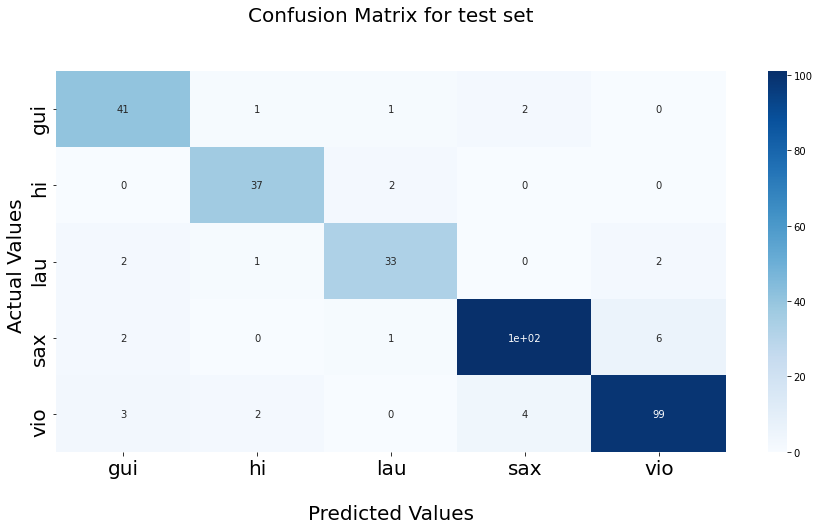

In [9]:
label_list =  ['gui','hi','lau','sax','vio']
ax = sns.heatmap(conf_mat_dict["val"], annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for test set\n\n',fontsize=20)
ax.set_xlabel('\nPredicted Values',fontsize=20)
ax.set_ylabel('Actual Values ',fontsize=20);

ax.xaxis.set_ticklabels(label_list,fontsize=20)
ax.yaxis.set_ticklabels(label_list,fontsize=20)
plt.show()

As you can see the data is not equally distributed among classes. 
Now we will normalize the heatmap for each class.

In [10]:
mat_tra = conf_mat_dict["train"]/conf_mat_dict["train"].sum(axis=1)[:,None]
mat_val = conf_mat_dict["val"]/conf_mat_dict["val"].sum(axis=1)[:,None]#normalize 

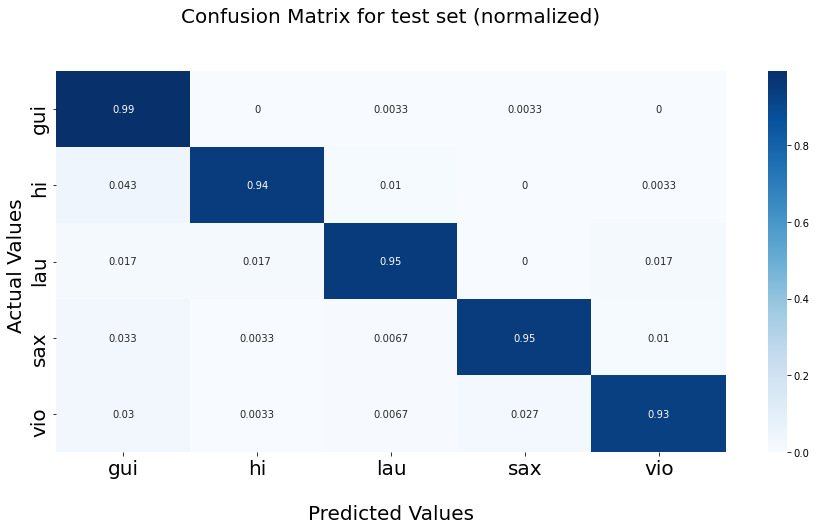

In [11]:
ax = sns.heatmap(mat_tra, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for test set (normalized)\n\n',fontsize=20)
ax.set_xlabel('\nPredicted Values',fontsize=20)
ax.set_ylabel('Actual Values ',fontsize=20)

ax.xaxis.set_ticklabels(label_list,fontsize=20)
ax.yaxis.set_ticklabels(label_list,fontsize=20)
plt.show()

The diagonal shows the percentage of the correct guesses of the model for each class. Now plot a bar chart
to see performance in each class for both validation and train sets

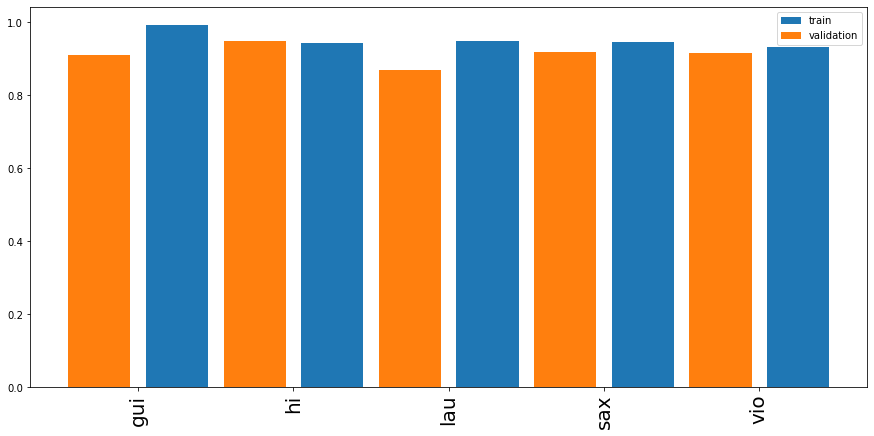

In [12]:
c = np.arange(0,10)
single = c[c%2!=0]
doble = c[c%2!=1]

plt.xticks(single-0.5,label_list,rotation=90,fontsize=20)
plt.bar(single,mat_tra.diag())
plt.bar(doble,mat_val.diag())
plt.legend(["train","validation"])
plt.show()

In [13]:
X_embedded = TSNE(n_components=2).fit_transform(feature_list.squeeze(1))
X_embedded.shape

(340, 2)

Using t-sne we will reduce the dimensionality of each feature vector. 
This will also get similar classes together in the coordinate system

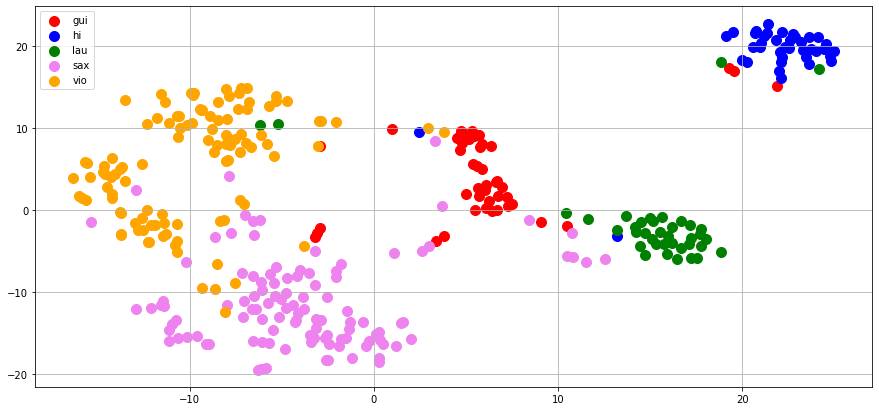

In [14]:
fig, ax = plt.subplots()

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: 'orange'}
group = gold_label_list.reshape(1,-1).squeeze(0).numpy()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(X_embedded[:,0][ix], X_embedded[:,1][ix], c = cdict[g], label = g, s = 100)
ax.legend(label_list)
plt.grid()

As it can be seen our model can seperate each class. Don't forget that while we project our feature vectors to 2D coordinate system we loose some information and get an imperfect representation. However this plot can still give meaningful information to us. You can try listening and comparing different audio samples to understand what each axis corresponds to (frequency, amplitude, etc.). You can also try understanding what causes formation of sub-groups in some classes such as violin. (If you remember from data analysis part violin class actually consists of violin and fiddle samples. Maybe one group corresponds to fiddle and the other group is actually violin)